In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster

# Stimulating compartments
Besides stimulating compartments via a bias current, we can also stimulate compartments by injecting spikes. These spikes can either come from within the network or outside the network from a spike generator. A spike generator is a class that can either generate spikes based on some algorithm, from a file or represent a hardware sensor such as a DVS camera.

Each spike generator has its own particular interface to configure it but can otherwise be connected to a network just like a compartment group.

Here we demonstrate the usage of the most basic spike generator which allows the user to define the specific spike times for each particular port of the spike generator.

![Stimulating Compartments](figures/jupyter_stimulating_compartments.png)

### Create network
Here we create a network consisting of a spike generator with **numSrc** input ports randomly connected to a compartment group of size **numDst**. 

In [2]:
net = nx.NxNet()
numSrc = 10
numDst = 20

# Create spike generator
sg = net.createSpikeGenProcess(numPorts=numSrc)

# Create destination compartment group
cxProto = nx.CompartmentPrototype(vThMant=2000, 
                                  compartmentCurrentDecay=int(1/10*2**12))
cxGrp = net.createCompartmentGroup(size=numDst, prototype=cxProto)

# Connect spike generator to compartment group with mixed sign random weights and random delays.
connProto = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
np.random.seed(0)
sg.connect(cxGrp, 
           prototype=connProto, 
           weight=np.random.randint(-100, 100, size=(numDst, numSrc)),
           delay=np.random.randint(0, 7, size=(1, numSrc)))

### Create and add input spikes to spike generator

In [3]:
# Create input spikes for each port of spike generator
numSteps = 200
spikingProbability = 0.05
inputSpikes = np.random.rand(numSrc, numSteps) < spikingProbability
# Find and add spike times to spike generator
spikeTimes = []
for i in range(numSrc):
    st = np.where(inputSpikes[i,:])[0].tolist()
    spikeTimes.append(st)
    sg.addSpikes(spikeInputPortNodeIds=i, 
                 spikeTimes=st)

### Create probes and run network

In [4]:
(uProbes,vProbes,sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                        nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                        nx.ProbeParameter.SPIKE])

net.run(numSteps)
net.disconnect()

SLURM is being run in background
Connecting to 134.134.68.80:18861
N2Driver: Running...
    Compiling synapses... Done (0.01s)
    Processing probes... Done (0.00s)
    Writing modified registers... Done (0.05s)
    Initializing... Done (0.01s)
    Preparing input... Done (0.02s)
    Executing... Done (0.10s)
    Processing timeSeries... Done (0.15s)
N2Driver: Finished (0.34s)


### Show results

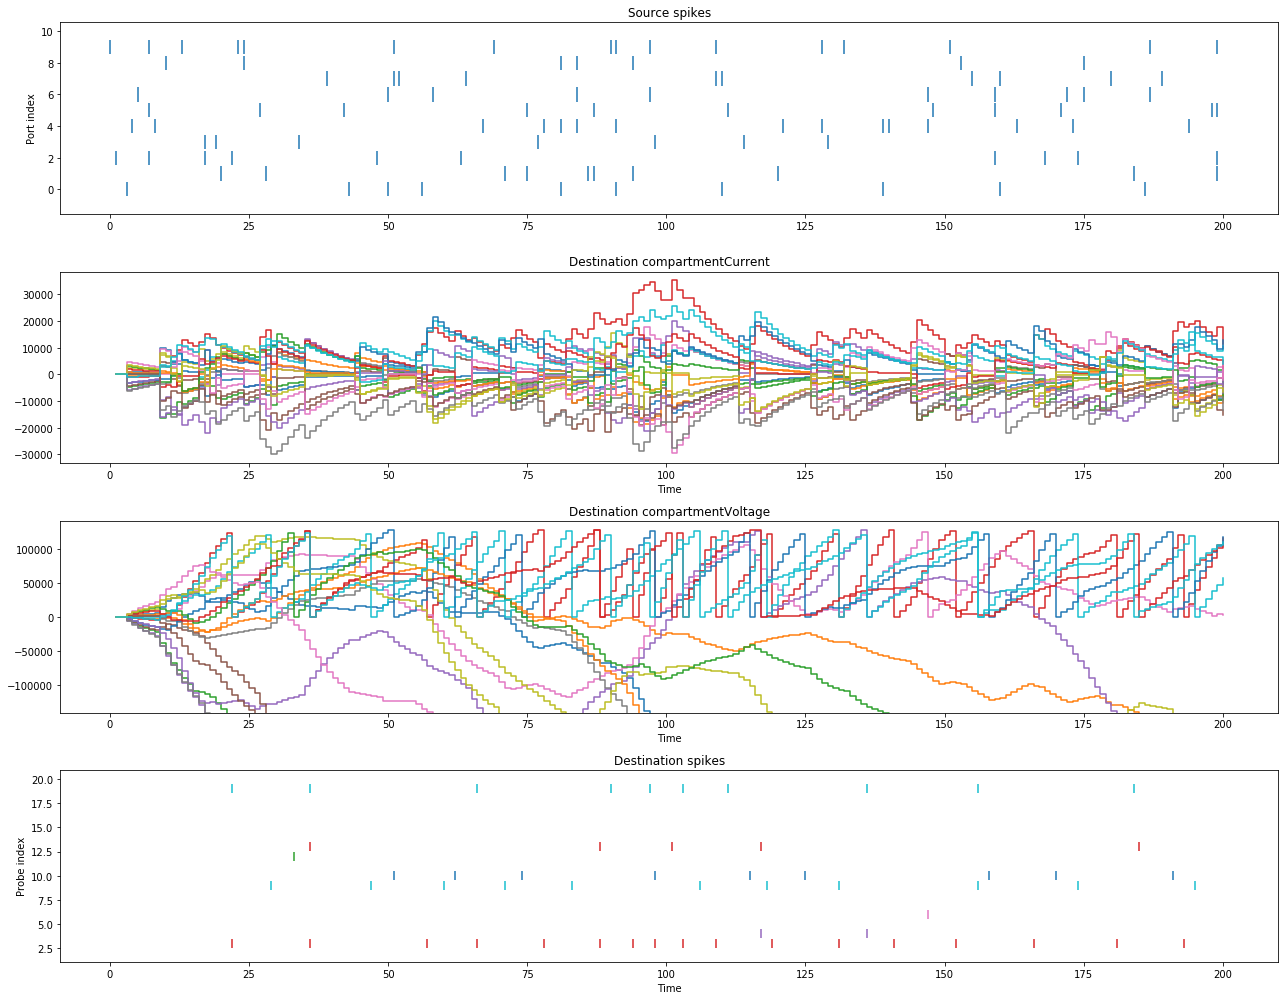

In [5]:
plt.figure(1, figsize=(18,14))

# Plot destination compartment current
ax1 = plt.subplot(4,1,2)
uh = uProbes.plot()
plt.title('Destination compartmentCurrent')

# Plot destination compartment voltage
ax2 = plt.subplot(4,1,3)
vh = vProbes.plot()
plt.ylim(-2200*64, 2200*64)
plt.title('Destination compartmentVoltage')

# Plot destination spikes
ax3 = plt.subplot(4,1,4)
sh = sProbes.plot(colors=[h.get_color() for h in uh])
ax3.set_xlim(ax1.get_xlim())
plt.title('Destination spikes')

# Plot source spikes
ax0 = plt.subplot(4,1,1)
sh = plotRaster(spikeTimes)
ax0.set_xlim(ax1.get_xlim())
plt.ylabel('Port index')
plt.title('Source spikes')

plt.tight_layout()
plt.show()

.. code-links:: python clear